<a href="https://colab.research.google.com/github/dokunoale/chagas/blob/main/notebooks/Simple_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple LSTM model for EGC Binary Classification

The following notebook demonstrates how to install the required libraries for this project and then illustrates a basic usage example. It first checks the current TensorFlow version and then runs a simple computation using TensorFlow.

## Dataset and dependecies loading

In [ ]:
!git clone https://github.com/dokunoale/chagas.git
!pip install -r chagas/requirements.txt

# Download the dataset
import gdown

url = "https://drive.google.com/file/d/1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC/view?usp=drive_link"
gdown.download(url, "dataset.zip", quiet=False, fuzzy=True)
!unzip -q /content/dataset.zip -d chagas/data/


Cloning into 'chagas'...
remote: Enumerating objects: 860, done.
remote: Counting objects: 100% (295/295), done.
remote: Compressing objects: 100% (224/224), done.
remote: Total 860 (delta 162), reused 110 (delta 71), pack-reused 565 (from 2)
Receiving objects: 100% (860/860), 19.83 MiB | 20.21 MiB/s, done.
Resolving deltas: 100% (436/436), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 128.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 31.3 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.1
    Uninstalling joblib-1.5.1:
      Successfully uninstalled joblib-1.5.1
  Attempting uninstall: h5py
    Found existing installation: h5py 3.14.0
    Uninstalling h5py-3.14.0:
      Successfully uninstalled h5py-3.14.0
  Attempting uninstall: scikit-le

Downloading...
From (original): https://drive.google.com/uc?id=1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC
From (redirected): https://drive.google.com/uc?id=1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC&confirm=t&uuid=1572f518-76ab-4625-9f88-ae6bb60f9baf
To: /content/dataset.zip
100%|██████████| 623M/623M [00:10<00:00, 60.5MB/s]


In [ ]:
import sys
sys.path.append("/content/chagas/src")

import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import AUC

This code sets up the validation and test datasets for a Chagas disease classification task using ECG recordings. It begins by defining a custom noise reduction filter (`FiltfiltNoiseReducer`) with parameters tailored for ECG signals sampled at 400 Hz. Then, using a data loader (`WfdbLoader`), it applies the filter and loads ECG recordings labeled for the presence or absence of Chagas disease from specified directories. The data is shuffled during loading to ensure randomized batches. Finally, the metadata for the test set is retrieved for further analysis or tracking.


In [ ]:
from preprocessing.tf_dataset_loader import WfdbLoader
from preprocessing.filters import FiltfiltNoiseReducer


data_path = "/content/chagas/data/big_splitted_dataset/"

# Noise reduction filter
filter = FiltfiltNoiseReducer(fs=400, iir_freq=60.0, butterworth_cutoff=5., lowpass_cutoff=60., verbose=True)

# training set loading and preprocessing
train = WfdbLoader(label = 'Chagas label')
train.add_filter(filter)
train.add_dataset(data_path + "train/positives")
train.add_dataset(data_path + "train/negatives")
X_train, y_train = train.load(shuffle=True, verbose=True)

# validation set loading and preprocessing
validation = WfdbLoader(label = 'Chagas label')
validation.add_filter(filter)
validation.add_dataset(data_path + "val/positives")
validation.add_dataset(data_path + "val/negatives")
X_val, y_val = validation.load(shuffle=True, verbose=True)

# test set loading and preprocessing
test = WfdbLoader(label = 'Chagas label')
test.add_filter(filter)
test.add_dataset(data_path + "test/positives")
test.add_dataset(data_path + "test/negatives")
X_test, y_test = test.load(shuffle=True, verbose=True)

# Array of dictionaries with more info for model analysis
y_test_info = test.get_metadata()

Filtering records - filtfilt: 100%|██████████| 2245/2245 [00:13<00:00, 172.12record/s]


## Training

In this cell, we define and compile a deep learning model based on a stacked Bidirectional LSTM architecture, designed for binary classification of 12-lead ECG signals.
- **Bidirectional LSTM layers** are employed to capture temporal dependencies in both forward and backward directions. This is particularly relevant for ECG analysis, where diagnostically important patterns may appear before or after a given time point.
- **Two stacked BiLSTM layers** are used to progressively extract richer temporal representations: the first focuses on short-term dependencies, while the second aggregates higher-level sequential patterns.
- **Dropout layers** (rate = 0.3) are inserted after each LSTM and dense layer to reduce overfitting, which is a common concern when working with biomedical data and deep models.
- **Fully connected layers** with 256 and 64 ReLU-activated units allow the model to transform the temporal features into a compact, discriminative representation for the classification task.
- The **output layer** is a single sigmoid-activated neuron, producing a probability score for the positive class, consistent with the binary classification objective.

The model is compiled using the Adam optimizer for stable training, binary cross-entropy as the loss function, and evaluation metrics including accuracy and AUC. The latter is especially useful for imbalanced datasets, providing a more informative measure than accuracy alone.

The call to model.summary() outputs the layer-by-layer structure of the model, including the number of trainable parameters, offering a transparent view of the architecture.

In [ ]:
def build_lstm_model(
    input_shape=(2800, 12),
    lstm_units=64,
    dropout_rate=0.3
):
    inputs = layers.Input(shape=input_shape, name='input_layer')  # (2800, 12)

    # Primo livello LSTM bidirezionale
    x = layers.Bidirectional(
        layers.LSTM(lstm_units, return_sequences=True, name='lstm_1'),
        name='bidirectional_lstm_1'
    )(inputs)
    x = layers.Dropout(dropout_rate, name='dropout_1')(x)

    # Secondo livello LSTM bidirezionale
    x = layers.Bidirectional(
        layers.LSTM(lstm_units, name='lstm_2'),
        name='bidirectional_lstm_2'
    )(x)
    x = layers.Dropout(dropout_rate, name='dropout_2')(x)

    # Dense layers
    x = layers.Dense(256, activation='relu', name='dense_1')(x)
    x = layers.Dropout(dropout_rate, name='dropout_3')(x)
    x = layers.Dense(64, activation='relu', name='dense_2')(x)

    # Output layer
    outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)

    model = models.Model(inputs, outputs, name='ECG_LSTM_Model')
    return model


# Compilazione del modello
model = build_lstm_model(input_shape=(2800, 12))
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

model.summary()

Model: "ECG_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2800, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_1            │ (None, 2800, 128)      │        39,424 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2800, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_2            │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,777 (733.50 KB)

 Trainable params: 187,777 (733.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callback: early stopping and saving best model
early_stop = EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_auc', mode='max', save_best_only=True)

callbacks = [early_stop, checkpoint]

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=30,
    callbacks=callbacks
)

Epoch 1/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 85s 293ms/step - accuracy: 0.5008 - auc: 0.5130 - loss: 0.6924 - val_accuracy: 0.5303 - val_auc: 0.5884 - val_loss: 0.6846
Epoch 2/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 77s 290ms/step - accuracy: 0.5356 - auc: 0.5598 - loss: 0.6864 - val_accuracy: 0.5945 - val_auc: 0.6411 - val_loss: 0.6657
Epoch 3/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 76s 289ms/step - accuracy: 0.5659 - auc: 0.5878 - loss: 0.6818 - val_accuracy: 0.5642 - val_auc: 0.6018 - val_loss: 0.6813
Epoch 4/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 83s 294ms/step - accuracy: 0.5511 - auc: 0.5777 - loss: 0.6810 - val_accuracy: 0.5865 - val_auc: 0.5899 - val_loss: 0.6794
Epoch 5/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 82s 294ms/step - accuracy: 0.6037 - auc: 0.6065 - loss: 0.6728 - val_accuracy: 0.6266 - val_auc: 0.6324 - val_loss: 0.6615
Epoch 6/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 77s 294ms/step - accuracy: 0.6214 - auc: 0.6199 - loss: 0.6651 - val_accuracy: 0.6310 - val_auc: 0.6315 - val_loss: 0.6576
Epoch 7/50
262/262 ━━━

## Model analysis

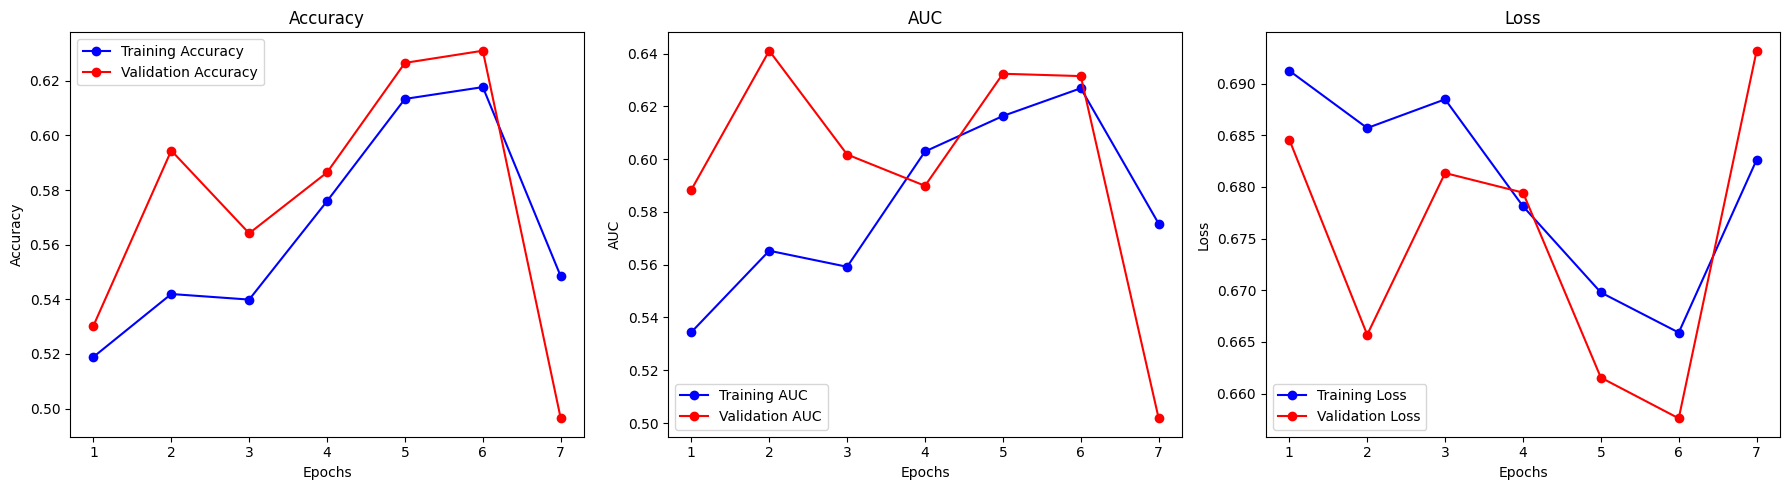

In [ ]:
from models.analysis import plot_training_metrics

# accuracy, AUC and loss plot
plot_training_metrics(history)

In [ ]:
from models.utils import find_optimal_threshold, compute_predictions
from sklearn.metrics import classification_report, accuracy_score


# Load the trained Keras model from file, specifying any custom layers used
model = tf.keras.models.load_model("best_model.keras")

# Generate predicted probabilities on the validation set
y_pred_probs = model.predict(X_val)

# Find the optimal classification threshold based on the validation set
threshold = find_optimal_threshold(y_val, y_pred_probs)

# Compute final predictions, predicted classes, and correctness flags on the test set
y_pred, y_pred_classes, correct = compute_predictions(model, X_test, y_test, threshold)

# Print a detailed classification report (precision, recall, f1-score, support)
print(classification_report(y_test, y_pred_classes))

# Compute and store the overall accuracy score
accuracy = accuracy_score(y_test, y_pred_classes)

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step
Optimal threshold: 0.470
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step
              precision    recall  f1-score   support

           0       0.58      0.59      0.58      1126
           1       0.58      0.58      0.58      1119

    accuracy                           0.58      2245
   macro avg       0.58      0.58      0.58      2245
weighted avg       0.58      0.58      0.58      2245



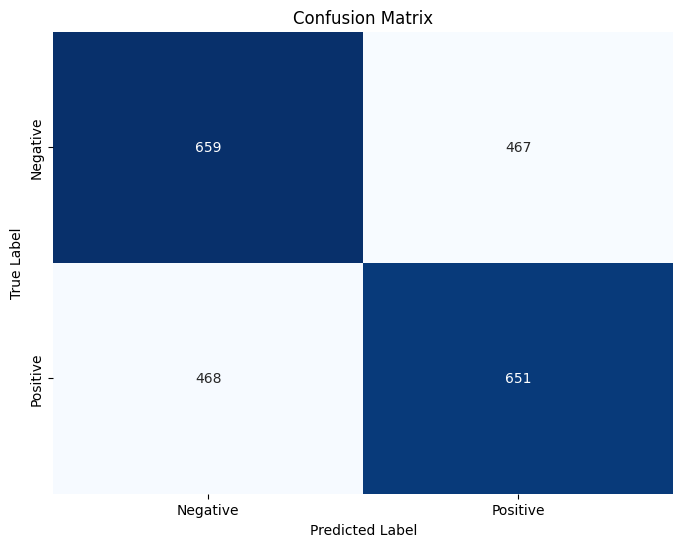

In [ ]:
from models.analysis import plot_confusion_matrix


# Confusion matrix
plot_confusion_matrix(y_test, y_pred_classes)

The next cell provides a summary of the distribution of the model's output scores.

- **Distribution of predictions**: Displays the distribution of predicted probabilities, highlighting correct (blue) and incorrect (red) classifications. A vertical dashed line indicates the 0.5 threshold, which may vary depending on the decision criterion.

- **Source distribution by model output**: Shows how the model's output scores (x-axis) are distributed across subgroups defined by data origin and label. This allows us to assess how different dataset segments are classified and to detect potential imbalances. Groups include:

    - Chagas-negative cases from CODE-15% (light teal),

    - Chagas-positive cases from CODE-15% (teal),

    - Chagas-positive cases from SaMi-Trop (yellow).

- **Age distribution for correct predictions**: Depicts the distribution of model outputs for correctly classified samples, stratified by age group. This provides insight into how prediction confidence varies across age.

- **Age distribution for incorrect predictions**: Analogous to the previous chart but focused on misclassifications. It helps identify age groups with higher error rates or ambiguous outputs.

- **Prediction success rate by age**: Summarizes the model's classification accuracy by age group, expressed as a percentage of correct predictions. Sample counts per group are reported above each bar for context.

71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step


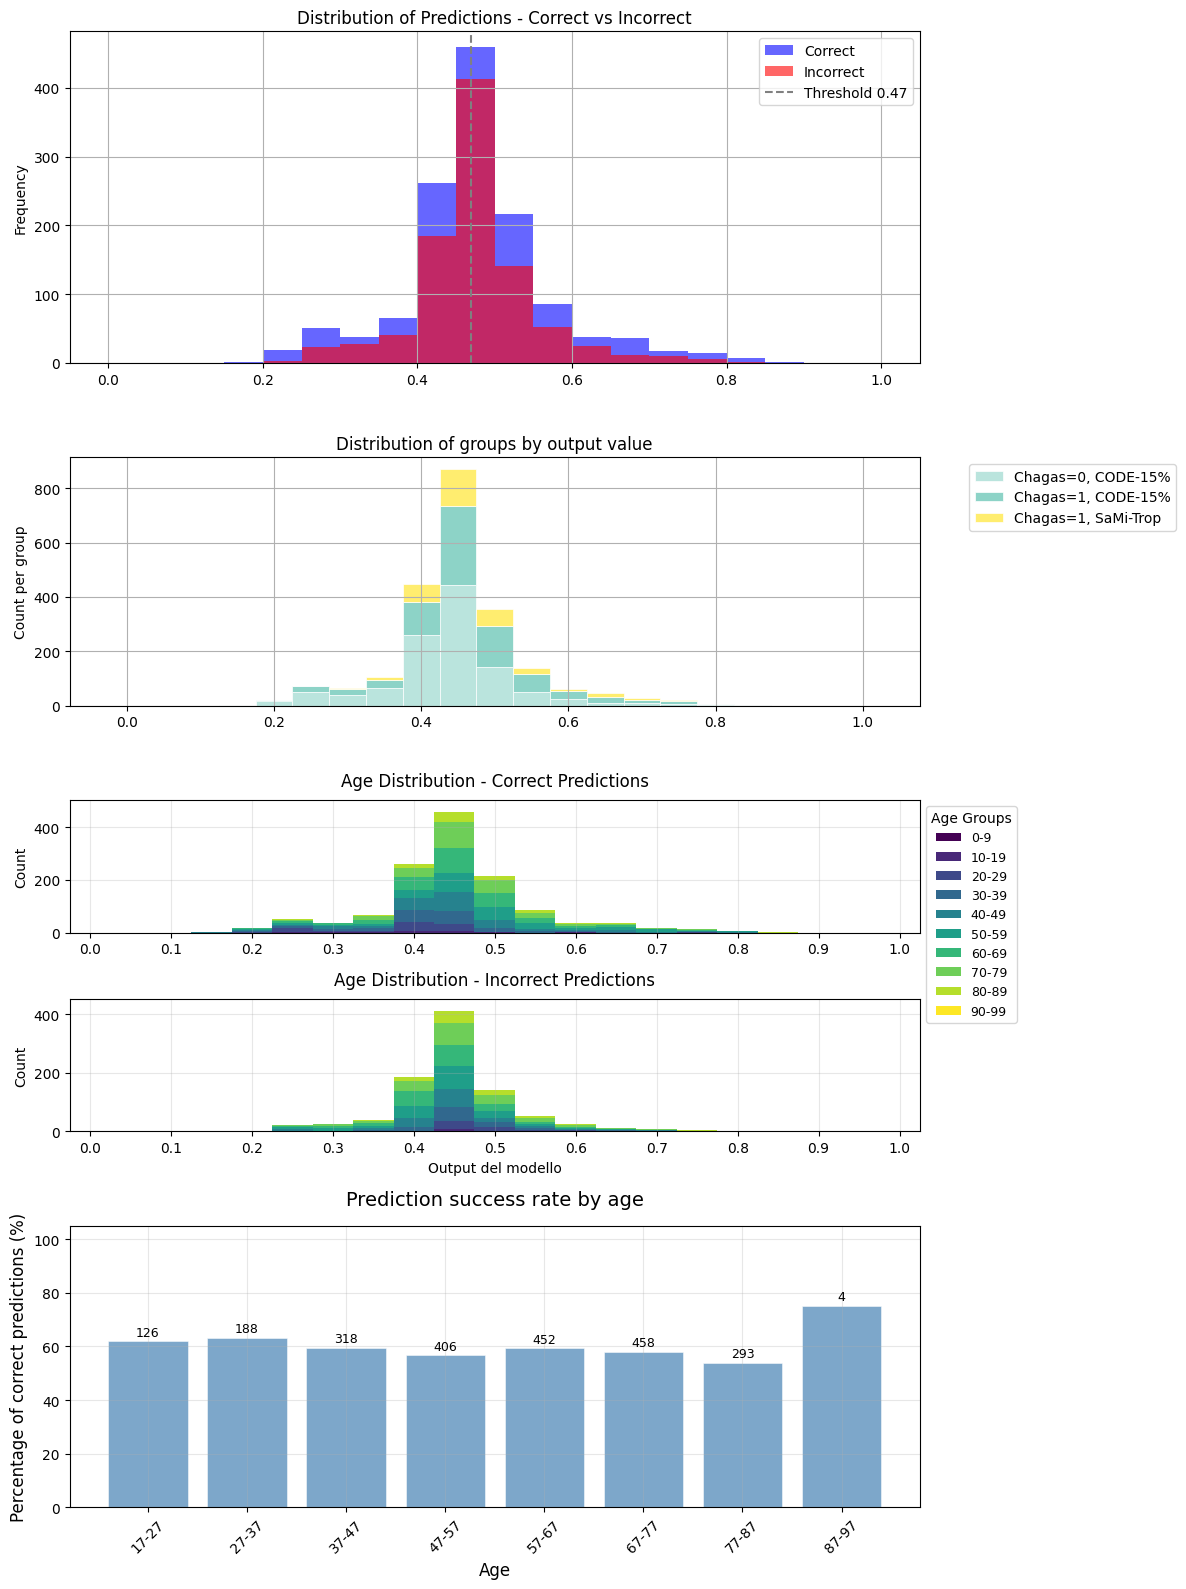

In [ ]:
from models.analysis import plot_model_analysis

plot_model_analysis(model, X_test, y_test, y_test_info, threshold, return_pillow=False)